In [1]:
## Load necessary libraries
%matplotlib inline
from constructIDF import *
import pandas as pd
import numpy as np
import itertools
import argparse
import matplotlib.pyplot as plt

from matplotlib import rcParams

rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

### Step 1: Read file with hourly rainfall records.

The rainfall observations used in this example are from the station [COOP station id USC00360821](https://www.ncdc.noaa.gov/homr/#ncdcstnid=20016672&tab=MSHR) hourly time series (previously obtained and cleaned from the National Oceanic and Atmospheric Administration National Centers for Environmental Information accessed [here](https://www.ncei.noaa.gov/data/coop-hourly-precipitation/v2/)) 


In [2]:
# Specify path to hourly rainfall time series
path = "/Users/tanialopez/historical-IDF/example_data/USC00360821.csv"

Read data into a dataframe and examine.
Hourly rainfall observations are organized by date and record, with flags inherited from the NCEI data. For more information on the flag meanings, visit
https://www.ncei.noaa.gov/data/coop-hourly-precipitation/v2/doc/readme.csv.txt

In [3]:
station_data = pd.read_csv(path, index_col=0)
station_data.head()

,date,val,qflags,mflags
0,1960-05-24 00:00:00,NaN,M,
1,1960-05-24 01:00:00,NaN,M,
2,1960-05-24 02:00:00,NaN,M,
3,1960-05-24 03:00:00,NaN,M,
4,1960-05-24 04:00:00,NaN,M,


### Step 2: Construct Annual Maximum Series

IDF curves are constructed based on the Annual Maximum Series (AMS) or Partial Duration Series (PDS). In this tutorial, and given the functions implemented in `constructIDF` we will construct IDF based on AMS. The AMS corresponds to the maximum rainfall value accumulated during a specific duration for each year in record. We want to construct IDF curves for longer durations than one hour (e.g. 2 hours, 6 hours, etc.) and we can do so by aggregating the series above to the corresponding duration

In [4]:
# Specify durations for which IDF curves will be created
# From one hour, to 3 days.

durations = [1, 2, 3, 6, 12, 24, 48, 72]

In [5]:
# Reformat station data and specify durations to compute AMS
ts = AMS(path, durations)


In [6]:
# This is the data that will be fed into the AMS methods.
ts.reformatted_frame.head()

,date,val
0,1960-05-24 00:00:00,NaN
1,1960-05-24 01:00:00,NaN
2,1960-05-24 02:00:00,NaN
3,1960-05-24 03:00:00,NaN
4,1960-05-24 04:00:00,NaN


Calculate AMS for each duration specified above. There are two methods implemented in `constructIDF`: *fixed maxima* and *sliding maxima* algorithms. The algorithms are provided in 

> Papalexiou, S. M., Dialynas, Y. G., & Grimaldi, S. (2016). Hershfield factor revisited: Correcting annual maximum precipitation. Journal of Hydrology, 542, 884–895. https://doi.org/10.1016/j.jhydrol.2016.09.058

These two functions extract the annual maximum precipitation (AMS) from a precipitation time series. The two approaches arise from the need to account for the fact that precipitation is systematicall recorded. For example, at a meteorological station, someone will check the tipping bucket pluviographs at some fixed local time each day which is then recorded as a "daily rainfall time series" at a particular location. This case results in "fixed" records, but "fixed" records have been shown inappropriate for estimating rainfall maxima. Because rainfall is a continuous variable, discretizing it can result in biases when estimating extreme rainfall, so it is advised to estimate annual maximum series using the sliding maxima approach.

In [7]:
# Calculate AMS for each duration specified above.
# AMS can be calculated using sliding maxima. (This might take some time.)

out = ts.calculate_AMS('sliding')

In [8]:
#################
#               #
#  AMS TABLE    #
#               #
#################


## Take a look at the computed AMS for each duration

out.head()

,year,1H,2H,3H,6H,12H,24H,48H,72H
0,1960,0.78,0.860000,0.890000,1.390000,1.450000,1.920000,2.340000,2.540000
1,1961,1.48,1.973333,1.973333,1.973333,2.390000,2.870714,2.960714,3.223214
2,1962,1.72,2.293333,2.293333,2.293333,2.293333,2.293333,2.293333,2.960000
3,1963,1.52,1.720000,2.150000,2.850000,3.050000,3.729167,3.829167,3.839167
4,1964,1.73,1.790000,1.800000,1.831111,2.930000,3.139286,3.139286,3.139286


In [9]:
# To save the data above as a csv file, uncomment this cell and 
# change the savepath to your own desired location.


#--- To uncomment remove "#" from next line:

# save_path = ""

# out.to_csv(savepath)

### Step 3: Fit Generalized Extreme Value and obtain rainfall depths

The next step is to fit a generalized extreme value distribution to each duration's AMS. Once the parameters (location, scale and shape) are estimated, these are used to retrieve the return levels (in this case, rainfall depth) for different quantiles feed into the inverse of the CDF. Usually, the quantiles are equal to the inverse of the average recurrence interval (ARI) (e.g. 1/2 = 2-year).

`constructIDF` has one method that merges all these steps, but we need to specify if we want to construct confidence intervals. The method implemented in `constructIDF` is bootstrapping, so we also need to specify the number of bootsrapped samples. Default value is 1000, and using a smaller number is not recommended.

Other specification is the confidence level, alpha, used to estimate the confidence intervals. Default is 0.9 (90% confidence interval).


In this tutorial, we will compute confidence intervals at a 90% confidence level using 1000 bootstrapped samples.

```python
ci = True
alpha = 0.9
number_bootstrap = 1000
```

In [10]:
# Specifying values
ci = True 
alpha = 0.9
number_bootstrap = 1000

In [11]:
# Feeding the data and our specifications to the method.

data = IDF(out, ci, number_bootstrap, alpha)

# Construct IDF from the data we feed above and our specifications.
# Some errors will be displayed, no worries. This will take long time because
# of the number of bootsrapped samples.
# The constructed IDF is by default for the following ARI:
# 2-, 5-, 10-, 25-, 50-, 100-, 200-year

data.construct_IDF()


In [12]:
#################
#               #
#  IDF TABLE    #
#               #
#################

## We can access the dataframe with confidence bounds:
data.idf

,1H,2H,3H,6H,12H,24H,48H,72H
L2-yr,1.153205,1.249704,1.324691,1.504934,1.787051,2.156623,2.420371,2.673732
L5-yr,1.621677,1.753415,1.841137,2.047365,2.459439,2.994179,3.336998,3.635989
L10-yr,1.905042,2.041007,2.145744,2.384929,2.862409,3.526922,3.942912,4.261140
L25-yr,2.236247,2.345451,2.473752,2.718028,3.270609,4.125422,4.611500,5.018589
L50-yr,2.442461,2.529182,2.668615,2.967247,3.496976,4.516199,5.066361,5.490195
L100-yr,2.640688,2.685521,2.834047,3.165799,3.695145,4.833663,5.421951,5.908273
L200-yr,2.783849,2.836316,2.981801,3.356348,3.847422,5.141984,5.722412,6.272350
2-yr,1.263385,1.364631,1.446089,1.644411,1.958782,2.367013,2.647990,2.890940
5-yr,1.853381,1.995561,2.087220,2.318444,2.778353,3.348046,3.764988,4.065751
10-yr,2.282540,2.435497,2.538377,2.807134,3.332739,3.995653,4.537027,4.820108


### Step 3: Generate IDF curves

We can call the `plot_IDF` method to create the IDF curves and plot them.
We need to pass the path where the original data was stored, a path where to store
the figure and its format.

In [13]:
savepath = "/Users/tanialopez/historicalIDF"

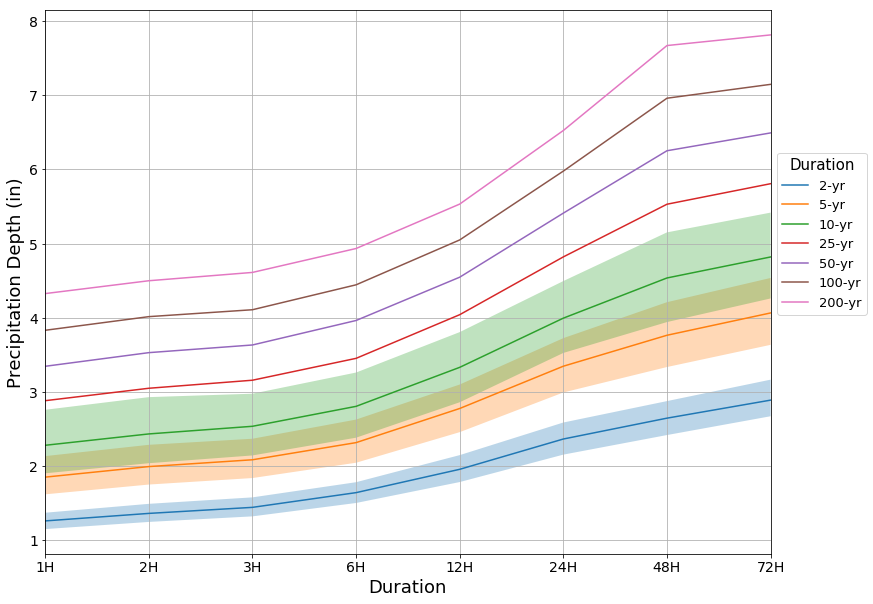

In [14]:
# This line generates a plot and saves in your folder specified above

data.plot_IDF(savepath, 'png') 